In [1]:
from __future__ import print_function
from datahandling import access_db, get_equip_names, get_dtype_names
from tinydb import Query
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from time import time
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from numpy import cumsum
from data_processing_pipeline import do_not_score_list
% matplotlib inline

C:\Users\Reinhard\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
db_X = access_db(3, True)

In [3]:
sv_db = access_db(0, True)

In [10]:
# db_X.purge()

In [5]:
Q = Query()

In [6]:
ingredients = ['PVC', 'filler', 'FR', 'stabiliser', 'DINP', 'LDH', 'spherical_filler']

In [7]:
equip_names = get_equip_names(sv_db)
equip_names

[u'colour', u'LOI', u'MCC', u'thermomat', u'tensile', u'rheomix', u'ConeCal']

In [8]:
sv_db.remove((Q.sample_number == 35))

[]

Populate X from single value database and store in new db

In [11]:
X = []
tm = time()
d_types_skip = do_not_score_list()

if not db_X.all():
    d_type_descr = []
    for sample_no in range(53):
        sample_no += 1
        
        if sample_no == 35:
            continue
        
        data_p_sample = []

        for ing in ingredients:
            entry = sv_db.search((Q.sample_number == sample_no) &
                                 (Q.ingredient == ing))
            val = entry[0]['value']
            data_p_sample.append(val)
            
            if sample_no == 1:
                d_type_descr.append('MassFrac ' + ing) 

        for en in equip_names:
            d_type_names = get_dtype_names(sv_db, en)
            d_type_names = [i for i in d_type_names if i not in d_types_skip]
            for dtn in d_type_names:
                entry = sv_db.search((Q.sample_number == sample_no) &
                                     (Q.equipment_name == en) &
                                     (Q.data_type == dtn))

                if entry:
                    val = entry[0]['value']
                else:
                    val = None

                data_p_sample.append(val)
                
                if sample_no == 1:
                    d_type_descr.append(en + ' ' + dtn)

        X.append(data_p_sample)
    
    entry = {'X': X,
             'd_type_descr': d_type_descr}
    db_X.insert(entry)

req_time = time() - tm
print(req_time)

95.6349999905


Database has missing values, missing values can either be replaced by mean or the incomplete rows are excluded from X

In [12]:
X = db_X.all()[0]['X']
impute = False
if impute:
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(X)
    X = imp.transform(X)
else:
    # Removing all incomplete samples
    X = [sample for sample in X if None not in sample]

Do PCA

In [13]:
X_std = StandardScaler().fit_transform(X)

In [15]:
len(X_std)

17

In [16]:
my_pca = PCA(n_components=len(X_std[0]))

In [17]:
my_pca.fit(X_std)

PCA(copy=True, n_components=40, whiten=False)

Analyse PCA results by looking at principal components with highest explained variance

In [18]:
comp = my_pca.components_

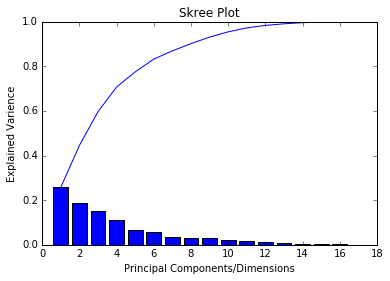

In [19]:
exp_var = my_pca.explained_variance_ratio_
plt.bar([i + 1 for i in range(len(exp_var))], exp_var, 0.8, align='center')
plt.plot([i + 1 for i in range(len(exp_var))], cumsum(exp_var))
plt.title('Skree Plot')
plt.xlabel('Principal Components/Dimensions')
plt.ylabel('Explained Varience')

In [20]:
descr = db_X.all()[0]['d_type_descr']

In [21]:
comp = [list(c) for c in comp]

In [22]:
d = [descr] + comp

In [23]:
df = DataFrame(data=d).T

Is this the decomposition matrix?

In [24]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,MassFrac PVC,-0.00257489,-0.336867,-0.0658268,0.0491316,0.0169774,-0.14762,-0.0228605,-0.106779,0.152093,-0.102871,0.0204221,-0.0773397,0.0238354,-0.00609421,-0.0182141,-0.248065,-0.649028
1,MassFrac filler,0.120593,0.252116,-0.0416433,-0.0246424,-0.246236,0.196114,0.085628,-0.0147105,-0.0934115,0.203988,0.23721,-0.0151343,0.11711,0.116139,0.0176101,0.0639689,-0.0200755
2,MassFrac FR,0.0968284,-0.0214915,0.336078,-0.0328272,0.145675,-0.190878,-0.0228717,0.0456448,-0.179152,-0.0991375,-0.0172143,0.0457657,-0.0404355,-0.0958851,-0.0660448,0.435335,0.0577273
3,MassFrac stabiliser,0.00365108,-0.247486,-0.0931057,0.00813464,0.230911,-0.0510988,-0.0924123,-0.245128,-0.406757,0.170263,-0.084433,0.0308552,0.222264,0.180157,0.0575242,-0.0113916,0.112681
4,MassFrac DINP,-0.288792,0.0216992,0.128974,-0.0349323,0.00936012,-0.085571,0.00401397,-0.0364421,0.018357,0.0312505,-0.0929284,0.0613463,-0.0626134,-0.0644341,0.037739,-0.0920915,-0.231625
5,MassFrac LDH,-0.0217508,0.112472,-0.22993,-0.178077,0.265642,-0.191945,-0.185483,0.0750705,0.0206011,-0.049239,-0.223854,-0.220253,-0.316673,-0.284323,0.0633095,0.1135,0.116679
6,MassFrac spherical_filler,0.0363116,0.0255141,-0.0496155,0.225623,0.116176,0.329823,0.0513496,0.337879,0.289654,-0.336709,-0.297636,0.26417,-0.046395,0.0780193,-0.0880923,-0.0803212,0.115409
7,colour YI,0.0889047,0.155111,-0.212719,-0.177557,-0.000605739,-0.23721,-0.129599,-0.0837002,0.165205,-0.323837,-0.114943,-0.201068,-0.00618219,-0.0936736,0.0102271,-0.152378,-0.0311102
8,LOI Final,0.260301,-0.11619,0.101578,0.0341194,0.164247,-0.0909683,-0.0244195,0.117342,-0.0716823,-0.000738727,0.113817,-0.043637,-0.00933241,-0.0160989,-0.208481,0.129403,-0.065721
9,MCC t_HR_kJpg,-0.253671,-0.0898951,0.0350424,-0.12833,-0.226435,0.0686737,0.145455,-0.0304647,-0.0150024,0.0129547,-0.00456162,0.0828033,-0.0207726,-0.215654,-0.0407124,-0.0922606,0.236657


In [25]:
prin_comp = 1
top = 5
sort_df = df.reindex(df[prin_comp].abs().sort_values(ascending=False).index)
clipped_df = sort_df.head(n=top)[[0, prin_comp]]
clipped_df

,0,1
16,MCC t_HR_peak_1_kJpg,-0.298359
4,MassFrac DINP,-0.288792
23,tensile epsilon_break_%_mean,-0.280063
26,tensile epsilon_max_%_mean,-0.278718
8,LOI Final,0.260301


In [26]:
names = clipped_df[0].tolist()

In [27]:
names

[u'MCC t_HR_peak_1_kJpg',
 u'MassFrac DINP',
 u'tensile epsilon_break_%_mean',
 u'tensile epsilon_max_%_mean',
 u'LOI Final']

In [28]:
df_2 = DataFrame(data=X_std, columns=descr)[names]

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

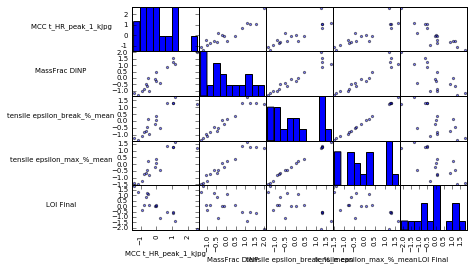

In [29]:
Axes = scatter_matrix(df_2)#, diagonal='kde')
n = len(df_2.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = Axes[x, y]
        # to make x axis name vertical  
#         ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

size = 7
[plt.setp(item.yaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', size) for item in Axes.ravel()]